# Transport between Port Aransas and Surfside

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import matplotlib as mpl
import tracpy.tools
from matplotlib.path import Path
import matplotlib.patches as Patches
from glob import glob
mpl.rcParams.update({'font.size': 14})

colu = '#218983'  # upcoast color
cold = '#cb6863'  # downcoast color

In [ ]:
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['land'])
pc = cartopy.crs.PlateCarree()
merc = cartopy.crs.Mercator(central_longitude=-85.0)

latpa, lonpa = 27.834750, -97.047372
latss, lonss = 28.934928, -95.294881

# load in grid
proj = tracpy.tools.make_proj('nwgom-pyproj')
grid = tracpy.inout.readgrid('../../grid.nc', proj)
lon_rho = grid.lon_rho[1:-1,1:-1]
lat_rho = grid.lat_rho[1:-1,1:-1]
x_rho, y_rho = proj(lon_rho, lat_rho)
angle = grid.angle_rho[1:-1,1:-1]  # theta to rotate wind vectors


In [195]:
d = np.load('../../shelf_transport/calcs/coastpaths.npz', encoding='latin1') # use paths in grid space
pathsg = d['pathsg']
pathsxy = d['pathsxy']
outerpathg = d['outerpathg'].item()
d.close()


# convert from grid coords to xy
loncoast, latcoast, _ = tracpy.tools.interpolate2d(outerpathg.vertices[:,0], outerpathg.vertices[:,1], grid, 'm_ij2ll')


# xcoast, ycoast, _ = tracpy.tools.interpolate2d(outerpathg.vertices[:,0], outerpathg.vertices[:,1], grid, 'm_ij2xy')

outerpathll = Path(np.vstack((loncoast,latcoast)).T)
# outerpathx, outerpathy, _ = tracpy.tools.interpolate2d(loncoast, latcoast, grid, 'd_ll2xy')


# distance along the coast boxes
# THIS PROJECTION IS NOT EQUAL DISTANCE
# # code from plot_sampledrifters.py
# dist = np.zeros(len(pathsxy))
# verts0 = pathsxy[0].vertices
# for i, path in enumerate(pathsxy):
#     verts1 = path.vertices
#     dist[i:] += np.sqrt((verts1[0,0]-verts0[0,0])**2+(verts1[0,1]-verts0[0,1])**2)
#     verts0 = verts1.copy()
# dist /= 1000 # convert to km
# dmax = dist.max()
# ae = cartopy.crs.AzimuthalEquidistant(central_longitude=-95, central_latitude=28)


dist = np.zeros(len(pathsg))
lonpath, latpath, _ = tracpy.tools.interpolate2d(pathsg[0].vertices[:,0], pathsg[0].vertices[:,1], grid, 'm_ij2ll')
spathll = shapely.geometry.LinearRing(zip(lonpath,latpath))  # shapely object for path in ll
spathxy = ae.project_geometry(spathll, src_crs=pc)[0][0]  # now in distance-preserving coords
# ae = cartopy.crs.AzimuthalEquidistant(central_longitude=lonpath[0], central_latitude=latpath[0])
cen0 = spathxy.centroid  # centroid in xy of 1st box
for i, path in enumerate(pathsg):
    lonpath, latpath, _ = tracpy.tools.interpolate2d(path.vertices[:,0], path.vertices[:,1], grid, 'm_ij2ll')
#     ae = cartopy.crs.AzimuthalEquidistant(central_longitude=lonpath[0], central_latitude=latpath[0])
    spathll = shapely.geometry.LinearRing(zip(lonpath,latpath))  # shapely object for path in ll
    spathxy = ae.project_geometry(spathll, src_crs=pc)[0][0]  # now in distance-preserving coords
    cen1 = spathxy.centroid
#     print(cen1.distance(cen0)/1000.)
    dist[i:] += cen1.distance(cen0)
#     dist[i:] += np.sqrt((verts1[0,0]-verts0[0,0])**2+(verts1[0,1]-verts0[0,1])**2)
    cen0 = cen1
dist /= 1000 # convert to km
dmax = dist.max()


## Map

Use map to determine along-coast distances of two locations and what coast boxes to use to represent each.

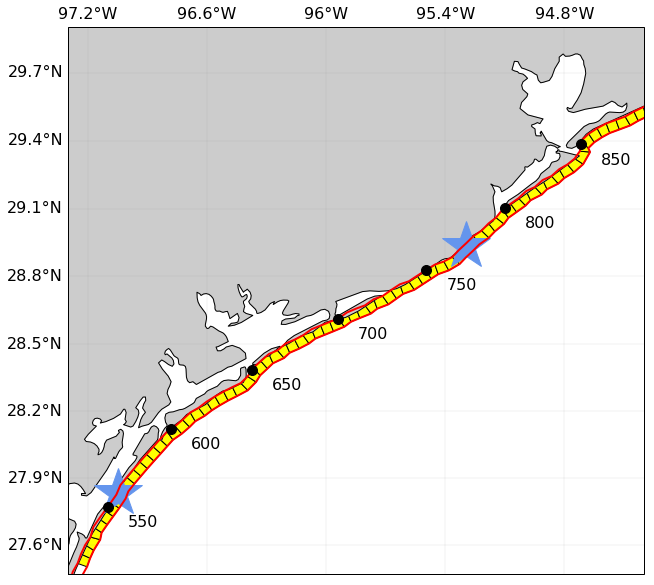

In [204]:
mpl.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(12, 8))# (9.4, 7.7))
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-97.3, -94.4, 27.47, 29.9], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  # coastline resolution options are '110m', '50m', '10m'

ax.plot([lonpa, lonss], [latpa, latss], '*', color='cornflowerblue', markersize=50, transform=pc)

# Add outer path
# ax.plot(loncoast, latcoast, 'r', transform=pc)

ax.plot(*coastxy[0].xy, color='r', lw=2, transform=ae)

for i, dd in enumerate(np.arange(550000,900000,50000)):
#     if i <= 4:
#         dx = 2e4; dy = 0
#     elif i >= 5 and i <= 9:
#         dx = 2e4; dy= -2e4
#     elif i == 12:
#         dx = -2e4; dy = -5e4
#     elif i == 14:
#         dx = 0; dy = -6e4
#     elif i == 15:
#         dx = 2e4; dy = 0
#     elif i == 16:
#         dx = 2e4; dy = -2e4
#     elif i>=9:
#         dx = 0; dy = -4e4
    dx = 1e4; dy = -1e4
    pt = coastxy[0].interpolate(dd).xy
    ax.plot(*pt, '.', markersize=20, color='k', transform=ae)
    ax.text(pt[0][0] + dx, pt[1][0] + dy, '%d' % (dd/1000.), color='k', transform=ae)
    
    

# # Plot labels for boxes
# for (i, path), dis in zip(enumerate(pathsg[::10]), dist[::10]):
#     if (dis>510) and (dis<880):
#         # convert from grid coords to ll to save
#         pathslon, pathslat, _ = tracpy.tools.interpolate2d(path.vertices[:,0], path.vertices[:,1], grid, 'm_ij2ll')
#         ax.text(pathslon[0] + 0.25, pathslat[0], '%3d' % dis, fontsize=14, color='k', transform=pc)
        
#     cen1 = spathxy.centroid
#

# label boxes
patches = []
for i, path in enumerate(pathsg[105:180]):
    pathslon, pathslat, _ = tracpy.tools.interpolate2d(path.vertices[:,0], path.vertices[:,1], grid, 'm_ij2ll')
#     spathll = shapely.geometry.LinearRing(zip(lonpath,latpath))  # shapely object for path in ll
#     spathxy = ae.project_geometry(spathll, src_crs=pc)[0][0]  # now in distance-preserving coords
#     p = Path(np.vstack(spath.xy).T)
    p = Path(np.vstack((pathslon,pathslat)).T)
    ax.add_patch(Patches.PathPatch(p, facecolor='yellow', transform=pc))
#     if np.mod(i, 10) == 0:
#         ax.text(pathslon[0] + 0.25, pathslat[0], str(i+105), fontsize=15, color='g', transform=pc)


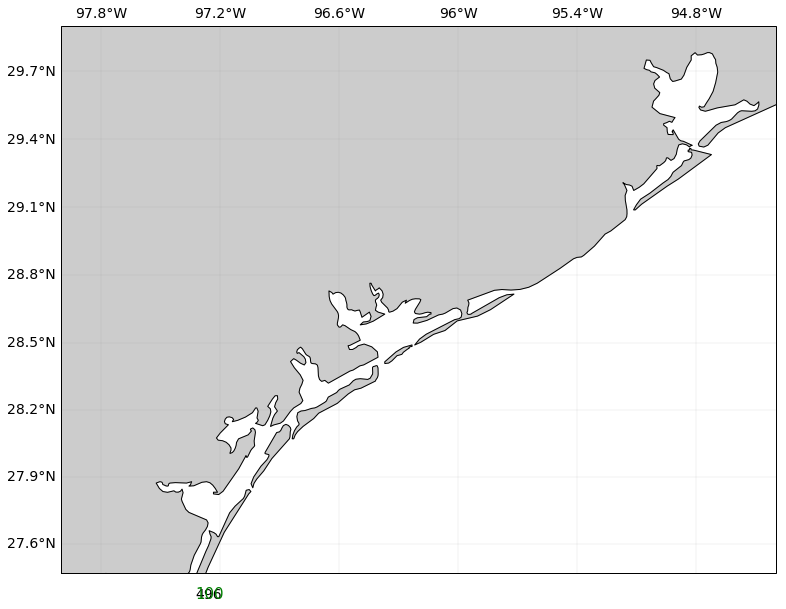

In [8]:
fig = plt.figure(figsize=(12, 8))# (9.4, 7.7))
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-98, -94.4, 27.47, 29.9], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  # coastline resolution options are '110m', '50m', '10m'

# Plot labels for boxes
i = 100
path = pathsg[i]
dis = dist[i]
# for (i, path), dis in zip(enumerate(pathsg[::10]), dist[::10]):
#     if (dis>510) and (dis<880):
# convert from grid coords to ll to save
pathslon, pathslat, _ = tracpy.tools.interpolate2d(path.vertices[:,0], path.vertices[:,1], grid, 'm_ij2ll')
ax.text(pathslon[0], pathslat[0], '%3d' % dis, fontsize=14, color='k', transform=pc)
        

# label boxes
patches = []
# for i, path in enumerate(pathsg[105:175]):
pathslon, pathslat, _ = tracpy.tools.interpolate2d(path.vertices[:,0], path.vertices[:,1], grid, 'm_ij2ll')
p = Path(np.vstack((pathslon,pathslat)).T)
ax.add_patch(Patches.PathPatch(p, facecolor='yellow', transform=pc))
ax.text(pathslon[0], pathslat[0], str(i), fontsize=15, color='g', transform=pc)


## Trends in transport between cytobots

### Everything

In [208]:
base = '../calcs/alongcoastconn/conn_in_time/pa_ss/'
t = np.load(base + 't.npz')['t']  # in decimal days
oname = base + 'aggregated.npz'
Files = glob(base + '2*.npz')
dates = [pd.Timestamp(File.split('/')[-1][:-4]) for File in Files]

if os.path.exists(oname):
    d = np.load(oname)
    ss2pa = d['ss2pa']
    pa2ss = d['pa2ss']
    d.close()
    
else:
    Files = glob(base + '2*.npz')

    pa2ss = np.empty((len(Files), len(t)))  # to save results, [start datetime, 30 days every 4 hours]
    ss2pa = np.empty((len(Files), len(t)))

    for i, File in enumerate(Files):
        d = np.load(File)
        pa2ss[i,:] = d['pa2ss']
        ss2pa[i,:] = d['ss2pa']
        d.close()
    np.savez(oname, pa2ss=pa2ss, ss2pa=ss2pa)

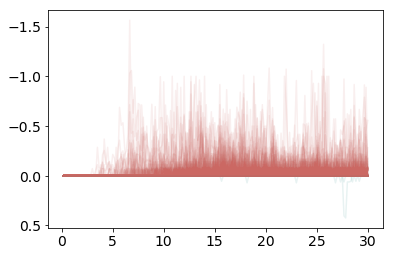

In [52]:
fig, ax = plt.subplots(1,1, figsize=(14,4))
ax.plot(t, pa2ss.T, color=colu, alpha=0.1);
ax.plot(t, -ss2pa.T, color=cold, alpha=0.1);
ax.invert_yaxis()

### Winter vs. Summer

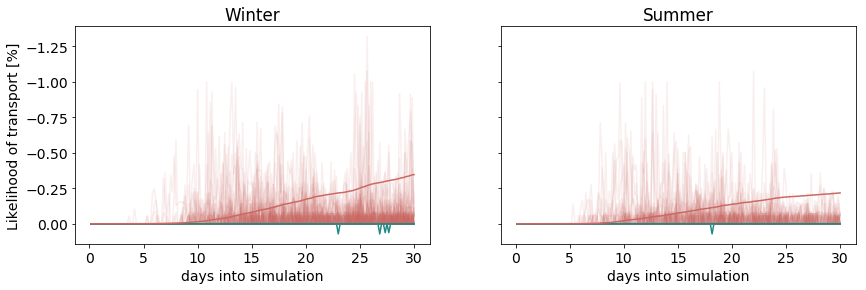

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=True, sharey=True)


inds = [date.month in [1,2,2,3] for date in dates]  # winter indices
# individual day lines of likelihood of transport between locations
axes[0].plot(t, pa2ss[inds,:].T, color=colu, alpha=1);
axes[0].plot(t, -ss2pa[inds,:].T, color=cold, alpha=0.1);
# averages of likelihoods
axes[0].plot(t, pa2ss[inds,:].mean(axis=0), color=colu, alpha=1);
axes[0].plot(t, -ss2pa[inds,:].mean(axis=0), color=cold, alpha=1);
# cumulative sum of likelihood in time
axes[0].plot(t, pa2ss[inds,:].mean(axis=0).cumsum(), color=colu, alpha=1);
axes[0].plot(t, -ss2pa[inds,:].mean(axis=0).cumsum(), color=cold, alpha=1);

axes[0].invert_yaxis()
axes[0].set_title('Winter')
axes[0].set_ylabel('Likelihood of transport [%]')
axes[0].set_xlabel('days into simulation')

inds = [date.month in [7,8,8,9] for date in dates]  # summer indices
axes[1].plot(t, pa2ss[inds,:].T, color=colu, alpha=1);
axes[1].plot(t, -ss2pa[inds,:].T, color=cold, alpha=0.1);
axes[1].plot(t, pa2ss[inds,:].mean(axis=0), color=colu, alpha=1);
axes[1].plot(t, -ss2pa[inds,:].mean(axis=0), color=cold, alpha=1);
axes[1].plot(t, pa2ss[inds,:].mean(axis=0).cumsum(), color=colu, alpha=1);
axes[1].plot(t, -ss2pa[inds,:].mean(axis=0).cumsum(), color=cold, alpha=1);

axes[1].set_title('Summer')
axes[1].set_xlabel('days into simulation')


### Likelihood of transport throughout year

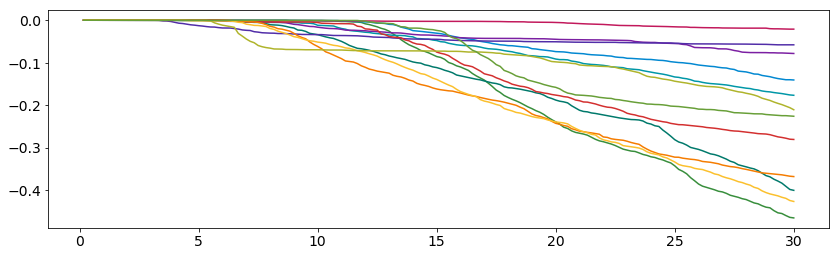

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(14,4))#, sharex=True, sharey=True)
colors = ['#388E3C', '#00796B', '#0097A7', '#0288D1', '#7B1FA2', '#512DA8', '#C2185B', '#D32F2F', '#F57C00', '#FBC02D', '#AFB42B', '#689F38']
# colors = ['#C2185B', '#D32F2F', '#F57C00', '#FBC02D', '#AFB42B', '#689F38', 
#           '#388E3C', '#00796B', '#0097A7', '#0288D1', '#7B1FA2', '#512DA8']

for month, color in zip(np.arange(1,13), colors):
    inds = [date.month == month for date in dates]  # timing indices
    
#     # individual day lines of likelihood of transport between locations
#     axes[0].plot(t, pa2ss[inds,:].T, color=colu, alpha=1);
#     axes[0].plot(t, -ss2pa[inds,:].T, color=cold, alpha=0.1);
#     # averages of likelihoods
#     axes[0].plot(t, pa2ss[inds,:].mean(axis=0), color=colu, alpha=1);
#     axes[0].plot(t, -ss2pa[inds,:].mean(axis=0), color=cold, alpha=1);
    # cumulative sum of likelihood in time
#     ax.plot(t, pa2ss[inds,:].mean(axis=0).cumsum(), color=colu, alpha=1);
    ax.plot(t, -ss2pa[inds,:].mean(axis=0).cumsum(), color=color, alpha=1);

# axes[0].invert_yaxis()
# axes[0].set_title('Winter')
# axes[0].set_ylabel('Likelihood of transport [%]')
# axes[0].set_xlabel('days into simulation')

# inds = [date.month in [7,8,8,9] for date in dates]  # summer indices
# axes[1].plot(t, pa2ss[inds,:].T, color=colu, alpha=1);
# axes[1].plot(t, -ss2pa[inds,:].T, color=cold, alpha=0.1);
# axes[1].plot(t, pa2ss[inds,:].mean(axis=0), color=colu, alpha=1);
# axes[1].plot(t, -ss2pa[inds,:].mean(axis=0), color=cold, alpha=1);
# axes[1].plot(t, pa2ss[inds,:].mean(axis=0).cumsum(), color=colu, alpha=1);
# axes[1].plot(t, -ss2pa[inds,:].mean(axis=0).cumsum(), color=cold, alpha=1);

# axes[1].set_title('Summer')
# axes[1].set_xlabel('days into simulation')


### Interannual variability

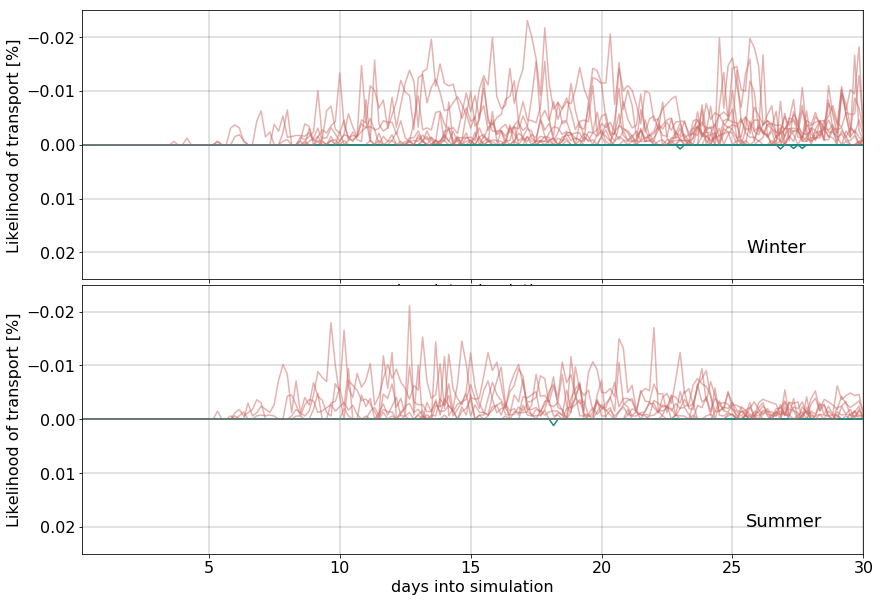

In [216]:
mpl.rcParams.update({'font.size': 16})

fig, axes = plt.subplots(2,1, sharex=True, sharey=True, figsize=(14,10))
fig.subplots_adjust(hspace=0.02)

for year in np.arange(2004,2015):
    
    inds = [date.month in [1,2,3] and date.year == year for date in dates]  # winter indices
#     # individual day lines of likelihood of transport between locations
#     axes[0].plot(t, pa2ss[inds,:].T, color=colu, alpha=1);
#     axes[0].plot(t, -ss2pa[inds,:].T, color=cold, alpha=0.1);
    # averages of likelihoods
    axes[0].plot(t, pa2ss[inds,:].mean(axis=0), color=colu, alpha=1);
    axes[0].plot(t, -ss2pa[inds,:].mean(axis=0), color=cold, alpha=0.5);
#     # cumulative sum of likelihood in time
#     axes[0].plot(t, pa2ss[inds,:].mean(axis=0).cumsum(), color=colu, alpha=1);
#     axes[0].plot(t, -ss2pa[inds,:].mean(axis=0).cumsum(), color=cold, alpha=1);


    inds = [date.month in [7,8,9] and date.year == year for date in dates]  # summer indices
#     axes[1].plot(t, pa2ss[inds,:].T, color=colu, alpha=1);
#     axes[1].plot(t, -ss2pa[inds,:].T, color=cold, alpha=0.1);
    axes[1].plot(t, pa2ss[inds,:].mean(axis=0), color=colu, alpha=1);
    axes[1].plot(t, -ss2pa[inds,:].mean(axis=0), color=cold, alpha=0.5);
#     axes[1].plot(t, pa2ss[inds,:].mean(axis=0).cumsum(), color=colu, alpha=1);
#     axes[1].plot(t, -ss2pa[inds,:].mean(axis=0).cumsum(), color=cold, alpha=1);

axes[0].invert_yaxis()
# axes[0].set_title('Transport between Surfside and Port Aransas in time')
axes[0].set_ylabel('Likelihood of transport [%]')
axes[0].set_xlabel('days into simulation')
# axes[1].set_title('Summer')
axes[1].set_ylabel('Likelihood of transport [%]')
axes[1].set_xlabel('days into simulation')

axes[0].set_xlim(t[0], t[-1])
axes[0].set_ylim(0.025,-0.025)
# axes[0].set_xticks(np.arange(100, 1600, 200), minor=True)
# axes[1].set_xticks(np.arange(100, 1600, 200), minor=True)

axes[0].grid(which='major', lw=1.5, color='k', alpha=0.15)
axes[0].grid(which='minor', lw=1.0, color='k', alpha=0.15)
axes[1].grid(which='major', lw=1.5, color='k', alpha=0.15)
axes[1].grid(which='minor', lw=1.0, color='k', alpha=0.15)

axes[0].text(0.85, 0.1, 'Winter', transform=axes[0].transAxes, fontsize=18)
axes[1].text(0.85, 0.1, 'Summer', transform=axes[1].transAxes, fontsize=18)


### How many times is it possible for any connectivity?

Look at nonzero connectivity for each time. So it will be like of all of the winter simulations, how many would have any nonzero connectivity.

#### Surfside to Port Aransas

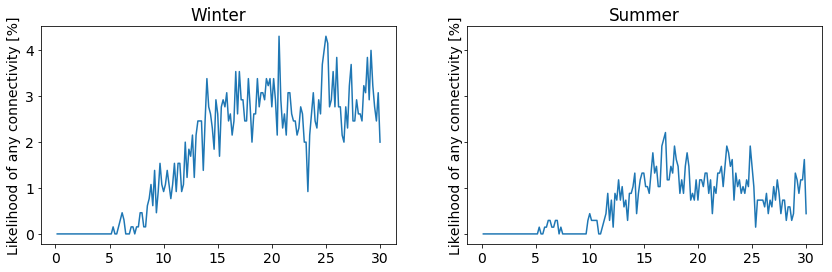

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=True, sharey=True)

inds = [date.month in [1,2] for date in dates]  # indices of files that started in jan or feb
axes[0].plot(t, ((ss2pa[inds,:] > 0).sum(axis=0)/inds.count(True))*100)  # drifters entering boxes at that time
# axes[0].plot(t, (((ss2pa[inds,:] > 0).sum(axis=0)/inds.count(True))*100))  # drifters entering boxes at that time
axes[0].set_ylabel('Likelihood of any connectivity [%]')
axes[0].set_title('Winter')

inds = [date.month in [7,8] for date in dates]  # indices of files that started in july or aug
axes[1].plot(t, ((ss2pa[inds,:] > 0).sum(axis=0)/inds.count(True))*100)
# axes[1].set_ylabel('Likelihood of any connectivity [%]')
axes[1].set_title('Summer')

In [218]:
i =0
s2p = np.zeros_like(ss2pa)
for irow, row in enumerate(ss2pa):  # loops through rows
    try:
        i1st = np.where(row > 0)[0][0]
        s2p[irow,i1st:] = 1
    except:
        pass


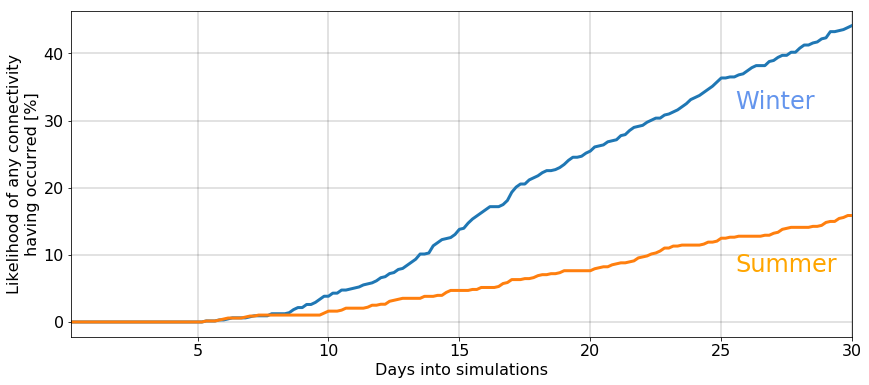

In [227]:
mpl.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(1,1, figsize=(14,6))
# fig.subplots_adjust(hspace=0.02)

inds = [date.month in [1,2] for date in dates]  # indices of files that started in jan or feb
ax.plot(t, ((s2p[inds,:] > 0).sum(axis=0)/inds.count(True))*100, lw=3)  # drifters entering boxes at that time
# axes[0].plot(t, (((ss2pa[inds,:] > 0).sum(axis=0)/inds.count(True))*100))  # drifters entering boxes at that time
ax.set_ylabel('Likelihood of any connectivity\nhaving occurred [%]')
# axes[0].set_title('Winter')
ax.set_xlabel('Days into simulations')

inds = [date.month in [7,8] for date in dates]  # indices of files that started in july or aug
ax.plot(t, ((s2p[inds,:] > 0).sum(axis=0)/inds.count(True))*100, lw=3)
ax.set_ylabel('Likelihood of any connectivity\nhaving occurred [%]')
# axes[1].set_title('Summer')
ax.set_xlabel('Days into simulations')

ax.set_xlim(t[0], t[-1])
# axes[0].set_ylim(0.025,-0.025)
# axes[0].set_xticks(np.arange(100, 1600, 200), minor=True)
# axes[1].set_xticks(np.arange(100, 1600, 200), minor=True)

ax.grid(which='major', lw=1.5, color='k', alpha=0.15)
ax.grid(which='minor', lw=1.0, color='k', alpha=0.15)
ax.grid(which='major', lw=1.5, color='k', alpha=0.15)
ax.grid(which='minor', lw=1.0, color='k', alpha=0.15)

ax.text(0.85, 0.7, 'Winter', transform=ax.transAxes, fontsize=24, color='cornflowerblue')
ax.text(0.85, 0.2, 'Summer', transform=ax.transAxes, fontsize=24, color='orange')


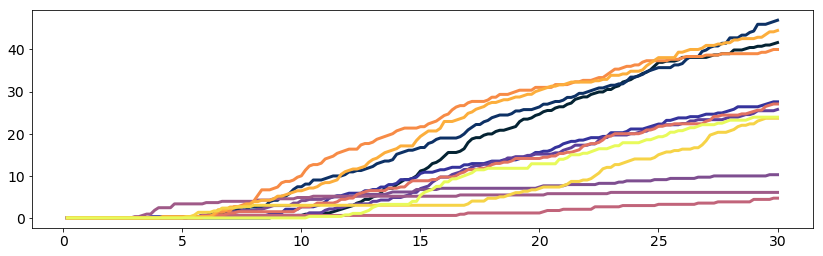

In [201]:
fig, ax = plt.subplots(1, 1, figsize=(14,4), sharex=True, sharey=True)

# alphas = np.linspace(0,1, 14)[-12:]
colors=cmo.thermal(np.linspace(0,1,12))[:,:3]  # from dark/cold to light/warm
# months = [7,8,6,9,5,10,4,11,3,12,2,1]  # warm to cold
# months = [1,2,12,11,3,10,4,9,8,5,6,7]
months = np.arange(1,13)

for month, color in zip(months, colors):
    inds = [date.month == month for date in dates]  # indices of files for that month
    ax.plot(t, ((s2p[inds,:] > 0).sum(axis=0)/inds.count(True))*100, color=color, lw=3)  # drifters entering boxes at that time


In [194]:
import cmocean.cm as cmo
cmo.thermal(np.linspace(0,1,10))
np.linspace(0,1,10)

array([ 0.        ,  0.11111111,  0.22222222,  0.33333333,  0.44444444,
        0.55555556,  0.66666667,  0.77777778,  0.88888889,  1.        ])

#### Port Aransas to Surfside

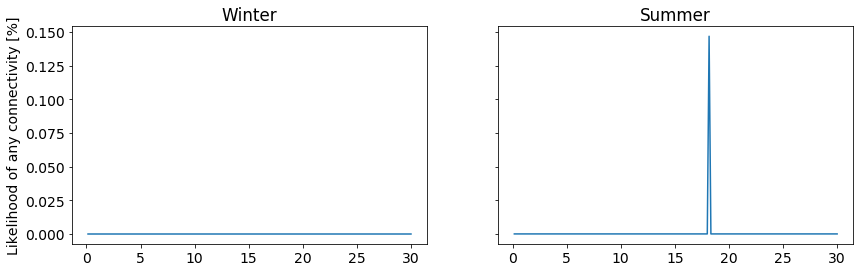

In [174]:
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=True, sharey=True)

inds = [date.month in [1,2] for date in dates]  # indices of files that started in jan or feb
axes[0].plot(t, ((pa2ss[inds,:] > 0).sum(axis=0)/inds.count(True))*100)  # drifters entering boxes at that time
axes[0].set_ylabel('Likelihood of any connectivity [%]')
axes[0].set_title('Winter')

inds = [date.month in [7,8] for date in dates]  # indices of files that started in july or aug
axes[1].plot(t, ((pa2ss[inds,:] > 0).sum(axis=0)/inds.count(True))*100)
axes[1].set_title('Summer')

In [175]:
i =0
p2s = np.zeros_like(pa2ss)
for irow, row in enumerate(pa2ss):  # loops through rows
    try:
        i1st = np.where(row > 0)[0][0]
        p2s[irow,i1st:] = 1
    except:
        pass


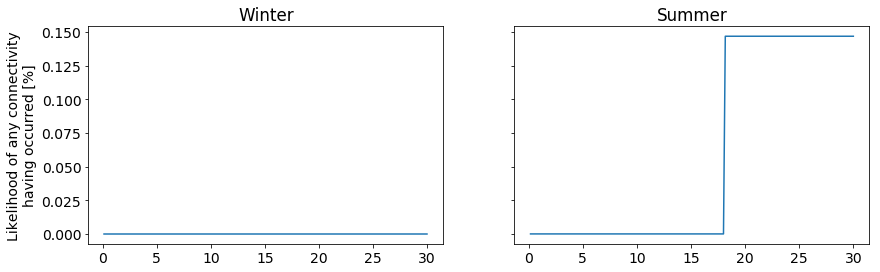

In [176]:
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=True, sharey=True)

inds = [date.month in [1,2] for date in dates]  # indices of files that started in jan or feb
axes[0].plot(t, ((p2s[inds,:] > 0).sum(axis=0)/inds.count(True))*100)  # drifters entering boxes at that time
axes[0].set_ylabel('Likelihood of any connectivity\nhaving occurred [%]')
axes[0].set_title('Winter')

inds = [date.month in [7,8] for date in dates]  # indices of files that started in july or aug
axes[1].plot(t, ((p2s[inds,:] > 0).sum(axis=0)/inds.count(True))*100)
axes[1].set_title('Summer')

### Time scales

## line representations of the along-coast connectivity matrices

In [121]:
base = '../calcs/alongcoastconn/'
lname = base + 'lines.npz'
import os
if os.path.exists(lname):
    d = np.load(lname)
    startingp = d['startingp']; startingn = d['startingn']
    endingp = d['endingp']; endingn = d['endingn']; dates = d['dates']; dist = d['dist']
    
else:
    from glob import glob
    # Files = glob(base + 'conn-????-??.npz')

    startingp = np.empty((len(Files), 342)); startingn = np.empty((len(Files), 342))
    endingp = np.empty((len(Files), 342)); endingn = np.empty((len(Files), 342))
    dates = []
    i = 0
    for year in np.arange(2004,2015):
        for month in np.arange(1,13):

            if year == 2014 and month > 8:
                continue
            date = str(year) + '-' + str(month).zfill(2)
            dates.append(date)
            File = base + 'conn-' + date + '.npz'
            mat = np.load(File)['mat']
            # make downcoast negative
            ix, iy = np.tril_indices(mat.shape[1], k=1)
            mat[ix, iy] = -mat[ix, iy]
            matp = np.ma.masked_where(mat<0, mat)
            matn = np.ma.masked_where(mat>0, mat)
            startingp[i,:] = matp.sum(axis=1)  # gives upcoast alongcoast conn as function of starting position
            endingp[i,:] = matp.sum(axis=0)
            startingn[i,:] = matn.sum(axis=1)  # gives downcoast alongcoast conn as function of starting position
            endingn[i,:] = matn.sum(axis=0)
            i += 1

    np.savez(lname, startingp=startingp, startingn=startingn, endingp=endingp, endingn=endingn, dates=dates, dist=dist)

## starting location vs ending location, seasonal average

### Build up!

### Only function of starting location, no interannual

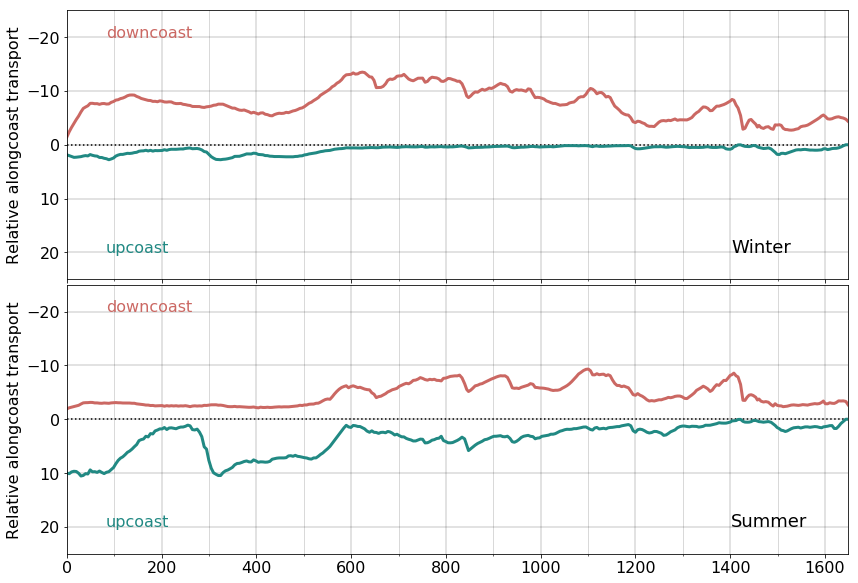

In [170]:
mpl.rcParams.update({'font.size': 16})

fig, axes = plt.subplots(2,1, sharex=True, sharey=True, figsize=(14,10))
fig.subplots_adjust(hspace=0.02)
## winter ##
inds = np.where([date.split('-')[-1] in ['01','02'] for date in dates])[0]

# upcoast transport from starting position
var = startingp[inds,:].mean(axis=0)
axes[0].plot(dist, var, color=colu, lw=3);
# std = startingp[inds,:].std(axis=0)
# axes[0].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# downcoast transport from starting position
var = startingn[inds,:].mean(axis=0)
axes[0].plot(dist, var, color=cold, lw=3);
# std = startingn[inds,:].std(axis=0)
# axes[0].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# # upcoast transport to ending position
# var = endingp[inds,:].mean(axis=0)
# axes[0].plot(dist, var, color=colu, ls='--', lw=2);
# std = endingp[inds,:].std(axis=0)
# axes[0].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# # downcoast transport to ending position
# var = endingn[inds,:].mean(axis=0)
# axes[0].plot(dist, var, color=cold, ls='--');
# std = endingn[inds,:].std(axis=0)
# axes[0].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

axes[0].hlines(0, dist[0], dist[-1], linestyle=':')
axes[0].text(0.85, 0.1, 'Winter', transform=axes[0].transAxes, fontsize=18)
axes[0].text(0.05, 0.9, 'downcoast', transform=axes[0].transAxes, fontsize=16, color=cold)
axes[0].text(0.05, 0.1, 'upcoast', transform=axes[0].transAxes, fontsize=16, color=colu)
axes[0].set_ylabel('Relative alongcoast transport')
# axes[0].set_ylabel('')
####

## summer ##
inds = np.where([date.split('-')[-1] in ['07','08'] for date in dates])[0]
# upcoast transport from starting position
var = startingp[inds,:].mean(axis=0)
axes[1].plot(dist, var, color=colu, lw=3);
# std = startingp[inds,:].std(axis=0)
# axes[1].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# downcoast transport from starting position
var = startingn[inds,:].mean(axis=0)
axes[1].plot(dist, var, color=cold, lw=3);
# std = startingn[inds,:].std(axis=0)
# axes[1].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# # upcoast transport to ending position
# var = endingp[inds,:].mean(axis=0)
# axes[1].plot(dist, var, color=colu, ls='--', lw=2);
# std = endingp[inds,:].std(axis=0)
# axes[1].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# # downcoast transport to ending position
# var = endingn[inds,:].mean(axis=0)
# axes[1].plot(dist, var, color=cold, ls='--');
# std = endingn[inds,:].std(axis=0)
# axes[1].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

axes[1].hlines(0, dist[0], dist[-1], linestyle=':')
axes[1].text(0.85, 0.1, 'Summer', transform=axes[1].transAxes, fontsize=18)
axes[1].text(0.05, 0.9, 'downcoast', transform=axes[1].transAxes, fontsize=16, color=cold)
axes[1].text(0.05, 0.1, 'upcoast', transform=axes[1].transAxes, fontsize=16, color=colu)
axes[1].set_ylabel('Relative alongcoast transport')
####

axes[0].set_xlim(dist[0], dist[-1])
axes[0].set_ylim(-25,25)
axes[0].invert_yaxis()
axes[0].set_xticks(np.arange(100, 1600, 200), minor=True)
axes[1].set_xticks(np.arange(100, 1600, 200), minor=True)

axes[0].grid(which='major', lw=1.5, color='k', alpha=0.15)
axes[0].grid(which='minor', lw=1.0, color='k', alpha=0.15)
axes[1].grid(which='major', lw=1.5, color='k', alpha=0.15)
axes[1].grid(which='minor', lw=1.0, color='k', alpha=0.15)


### Starting and ending locations

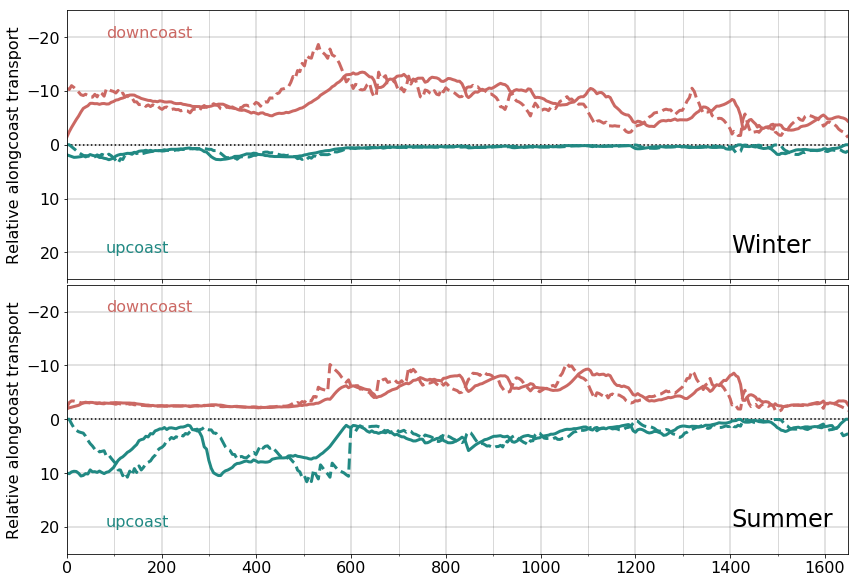

In [171]:
fig, axes = plt.subplots(2,1, sharex=True, sharey=True, figsize=(14,10))
fig.subplots_adjust(hspace=0.02)
## winter ##
inds = np.where([date.split('-')[-1] in ['01','02'] for date in dates])[0]

# upcoast transport from starting position
var = startingp[inds,:].mean(axis=0)
axes[0].plot(dist, var, color=colu, lw=3);
# std = startingp[inds,:].std(axis=0)
# axes[0].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# downcoast transport from starting position
var = startingn[inds,:].mean(axis=0)
axes[0].plot(dist, var, color=cold, lw=3);
# std = startingn[inds,:].std(axis=0)
# axes[0].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# upcoast transport to ending position
var = endingp[inds,:].mean(axis=0)
axes[0].plot(dist, var, color=colu, ls='--', lw=3);
# std = endingp[inds,:].std(axis=0)
# axes[0].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# downcoast transport to ending position
var = endingn[inds,:].mean(axis=0)
axes[0].plot(dist, var, color=cold, ls='--', lw=3);
# std = endingn[inds,:].std(axis=0)
# axes[0].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

axes[0].hlines(0, dist[0], dist[-1], linestyle=':')
axes[0].text(0.85, 0.1, 'Winter', transform=axes[0].transAxes, fontsize=24)
axes[0].text(0.05, 0.9, 'downcoast', transform=axes[0].transAxes, fontsize=16, color=cold)
axes[0].text(0.05, 0.1, 'upcoast', transform=axes[0].transAxes, fontsize=16, color=colu)
axes[0].set_ylabel('Relative alongcoast transport')
# axes[0].set_ylabel('')
####

## summer ##
inds = np.where([date.split('-')[-1] in ['07','08'] for date in dates])[0]
# upcoast transport from starting position
var = startingp[inds,:].mean(axis=0)
axes[1].plot(dist, var, color=colu, lw=3);
# std = startingp[inds,:].std(axis=0)
# axes[1].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# downcoast transport from starting position
var = startingn[inds,:].mean(axis=0)
axes[1].plot(dist, var, color=cold, lw=3);
# std = startingn[inds,:].std(axis=0)
# axes[1].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# upcoast transport to ending position
var = endingp[inds,:].mean(axis=0)
axes[1].plot(dist, var, color=colu, ls='--', lw=3);
# std = endingp[inds,:].std(axis=0)
# axes[1].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# downcoast transport to ending position
var = endingn[inds,:].mean(axis=0)
axes[1].plot(dist, var, color=cold, ls='--', lw=3);
# std = endingn[inds,:].std(axis=0)
# axes[1].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

axes[1].hlines(0, dist[0], dist[-1], linestyle=':')
axes[1].text(0.85, 0.1, 'Summer', transform=axes[1].transAxes, fontsize=24)
axes[1].text(0.05, 0.9, 'downcoast', transform=axes[1].transAxes, fontsize=16, color=cold)
axes[1].text(0.05, 0.1, 'upcoast', transform=axes[1].transAxes, fontsize=16, color=colu)
axes[1].set_ylabel('Relative alongcoast transport')
####

axes[0].set_xlim(dist[0], dist[-1])
axes[0].set_ylim(-25,25)
axes[0].invert_yaxis()
axes[0].set_xticks(np.arange(100, 1600, 200), minor=True)
axes[1].set_xticks(np.arange(100, 1600, 200), minor=True)

axes[0].grid(which='major', lw=1.5, color='k', alpha=0.15)
axes[0].grid(which='minor', lw=1.0, color='k', alpha=0.15)
axes[1].grid(which='major', lw=1.5, color='k', alpha=0.15)
axes[1].grid(which='minor', lw=1.0, color='k', alpha=0.15)


### Show starting location interannual

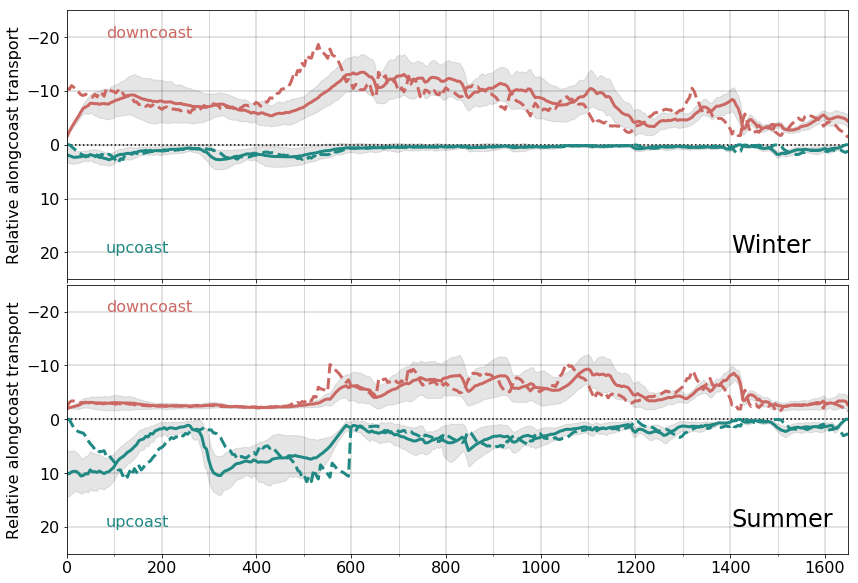

In [172]:
fig, axes = plt.subplots(2,1, sharex=True, sharey=True, figsize=(14,10))
fig.subplots_adjust(hspace=0.02)
## winter ##
inds = np.where([date.split('-')[-1] in ['01','02'] for date in dates])[0]

# upcoast transport from starting position
var = startingp[inds,:].mean(axis=0)
axes[0].plot(dist, var, color=colu, lw=3);
std = startingp[inds,:].std(axis=0)
axes[0].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# downcoast transport from starting position
var = startingn[inds,:].mean(axis=0)
axes[0].plot(dist, var, color=cold, lw=3);
std = startingn[inds,:].std(axis=0)
axes[0].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# upcoast transport to ending position
var = endingp[inds,:].mean(axis=0)
axes[0].plot(dist, var, color=colu, ls='--', lw=3);
# std = endingp[inds,:].std(axis=0)
# axes[0].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# downcoast transport to ending position
var = endingn[inds,:].mean(axis=0)
axes[0].plot(dist, var, color=cold, ls='--', lw=3);
# std = endingn[inds,:].std(axis=0)
# axes[0].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

axes[0].hlines(0, dist[0], dist[-1], linestyle=':')
axes[0].text(0.85, 0.1, 'Winter', transform=axes[0].transAxes, fontsize=24)
axes[0].text(0.05, 0.9, 'downcoast', transform=axes[0].transAxes, fontsize=16, color=cold)
axes[0].text(0.05, 0.1, 'upcoast', transform=axes[0].transAxes, fontsize=16, color=colu)
axes[0].set_ylabel('Relative alongcoast transport')
# axes[0].set_ylabel('')
####

## summer ##
inds = np.where([date.split('-')[-1] in ['07','08'] for date in dates])[0]
# upcoast transport from starting position
var = startingp[inds,:].mean(axis=0)
axes[1].plot(dist, var, color=colu, lw=3);
std = startingp[inds,:].std(axis=0)
axes[1].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# downcoast transport from starting position
var = startingn[inds,:].mean(axis=0)
axes[1].plot(dist, var, color=cold, lw=3);
std = startingn[inds,:].std(axis=0)
axes[1].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# upcoast transport to ending position
var = endingp[inds,:].mean(axis=0)
axes[1].plot(dist, var, color=colu, ls='--', lw=3);
# std = endingp[inds,:].std(axis=0)
# axes[1].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# downcoast transport to ending position
var = endingn[inds,:].mean(axis=0)
axes[1].plot(dist, var, color=cold, ls='--', lw=3);
# std = endingn[inds,:].std(axis=0)
# axes[1].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

axes[1].hlines(0, dist[0], dist[-1], linestyle=':')
axes[1].text(0.85, 0.1, 'Summer', transform=axes[1].transAxes, fontsize=24)
axes[1].text(0.05, 0.9, 'downcoast', transform=axes[1].transAxes, fontsize=16, color=cold)
axes[1].text(0.05, 0.1, 'upcoast', transform=axes[1].transAxes, fontsize=16, color=colu)
axes[1].set_ylabel('Relative alongcoast transport')
####

axes[0].set_xlim(dist[0], dist[-1])
axes[0].set_ylim(-25,25)
axes[0].invert_yaxis()
axes[0].set_xticks(np.arange(100, 1600, 200), minor=True)
axes[1].set_xticks(np.arange(100, 1600, 200), minor=True)

axes[0].grid(which='major', lw=1.5, color='k', alpha=0.15)
axes[0].grid(which='minor', lw=1.0, color='k', alpha=0.15)
axes[1].grid(which='major', lw=1.5, color='k', alpha=0.15)
axes[1].grid(which='minor', lw=1.0, color='k', alpha=0.15)


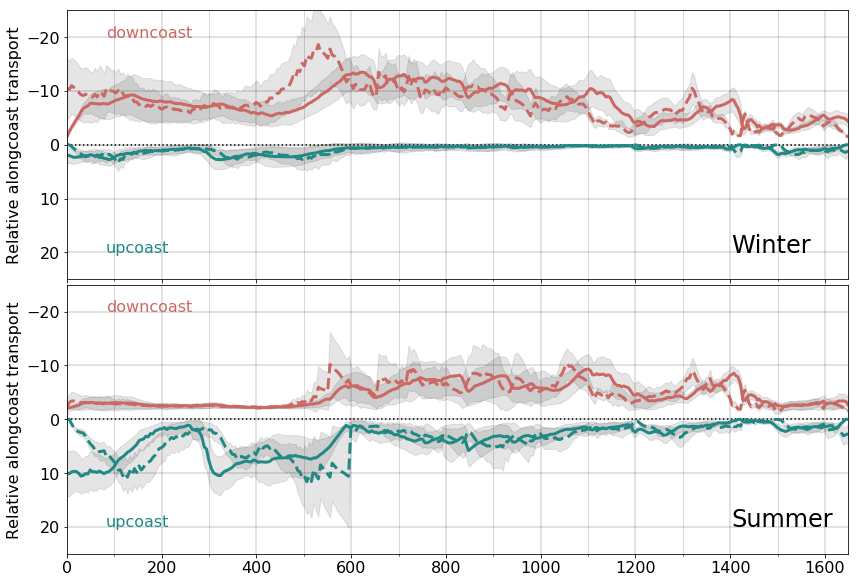

In [173]:
fig, axes = plt.subplots(2,1, sharex=True, sharey=True, figsize=(14,10))
fig.subplots_adjust(hspace=0.02)
## winter ##
inds = np.where([date.split('-')[-1] in ['01','02'] for date in dates])[0]

# upcoast transport from starting position
var = startingp[inds,:].mean(axis=0)
axes[0].plot(dist, var, color=colu, lw=3);
std = startingp[inds,:].std(axis=0)
axes[0].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# downcoast transport from starting position
var = startingn[inds,:].mean(axis=0)
axes[0].plot(dist, var, color=cold, lw=3);
std = startingn[inds,:].std(axis=0)
axes[0].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# upcoast transport to ending position
var = endingp[inds,:].mean(axis=0)
axes[0].plot(dist, var, color=colu, ls='--', lw=3);
std = endingp[inds,:].std(axis=0)
axes[0].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# downcoast transport to ending position
var = endingn[inds,:].mean(axis=0)
axes[0].plot(dist, var, color=cold, ls='--', lw=3);
std = endingn[inds,:].std(axis=0)
axes[0].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

axes[0].hlines(0, dist[0], dist[-1], linestyle=':')
axes[0].text(0.85, 0.1, 'Winter', transform=axes[0].transAxes, fontsize=24)
axes[0].text(0.05, 0.9, 'downcoast', transform=axes[0].transAxes, fontsize=16, color=cold)
axes[0].text(0.05, 0.1, 'upcoast', transform=axes[0].transAxes, fontsize=16, color=colu)
axes[0].set_ylabel('Relative alongcoast transport')
# axes[0].set_ylabel('')
####

## summer ##
inds = np.where([date.split('-')[-1] in ['07','08'] for date in dates])[0]
# upcoast transport from starting position
var = startingp[inds,:].mean(axis=0)
axes[1].plot(dist, var, color=colu, lw=3);
std = startingp[inds,:].std(axis=0)
axes[1].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# downcoast transport from starting position
var = startingn[inds,:].mean(axis=0)
axes[1].plot(dist, var, color=cold, lw=3);
std = startingn[inds,:].std(axis=0)
axes[1].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# upcoast transport to ending position
var = endingp[inds,:].mean(axis=0)
axes[1].plot(dist, var, color=colu, ls='--', lw=3);
std = endingp[inds,:].std(axis=0)
axes[1].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

# downcoast transport to ending position
var = endingn[inds,:].mean(axis=0)
axes[1].plot(dist, var, color=cold, ls='--', lw=3);
std = endingn[inds,:].std(axis=0)
axes[1].fill_between(dist, var + std, var - std, color='k', alpha=0.1);

axes[1].hlines(0, dist[0], dist[-1], linestyle=':')
axes[1].text(0.85, 0.1, 'Summer', transform=axes[1].transAxes, fontsize=24)
axes[1].text(0.05, 0.9, 'downcoast', transform=axes[1].transAxes, fontsize=16, color=cold)
axes[1].text(0.05, 0.1, 'upcoast', transform=axes[1].transAxes, fontsize=16, color=colu)
axes[1].set_ylabel('Relative alongcoast transport')
####

axes[0].set_xlim(dist[0], dist[-1])
axes[0].set_ylim(-25,25)
axes[0].invert_yaxis()
axes[0].set_xticks(np.arange(100, 1600, 200), minor=True)
axes[1].set_xticks(np.arange(100, 1600, 200), minor=True)

axes[0].grid(which='major', lw=1.5, color='k', alpha=0.15)
axes[0].grid(which='minor', lw=1.0, color='k', alpha=0.15)
axes[1].grid(which='major', lw=1.5, color='k', alpha=0.15)
axes[1].grid(which='minor', lw=1.0, color='k', alpha=0.15)


#### Interannual variability, either starting or ending position

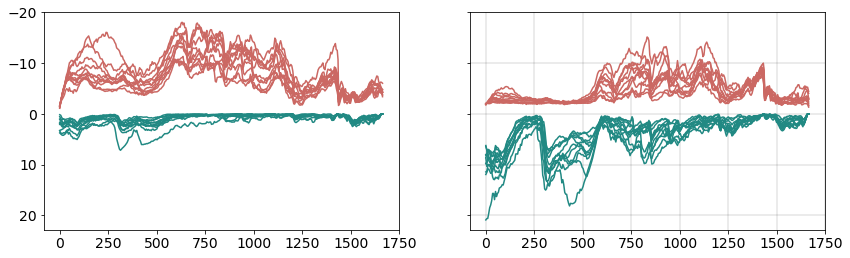

In [268]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(14,4))
for year in np.arange(2004,2015):
    inds = np.where([date.split('-')[-1] in ['01','02'] and date.split('-')[0] == str(year) for date in dates])[0]
    axes[0].plot(dist, startingp[inds,:].mean(axis=0), color=colu);
    axes[0].plot(dist, startingn[inds,:].mean(axis=0), color=cold);
#     axes[0].plot(dist, endingp[inds,:].mean(axis=0), color=colu, ls='--');
#     axes[0].plot(dist, endingn[inds,:].mean(axis=0), color=cold, ls='--');

    inds = np.where([date.split('-')[-1] in ['07','08'] and date.split('-')[0] == str(year) for date in dates])[0]
    axes[1].plot(dist, startingp[inds,:].mean(axis=0), color=colu);
    axes[1].plot(dist, startingn[inds,:].mean(axis=0), color=cold);
    
axes[0].invert_yaxis()
plt.grid(which='major', lw=1.5, color='k', alpha=0.1)
# plt.grid(which='minor', lw=1, color='k', alpha=0.05)


## overall map of coastal boxes

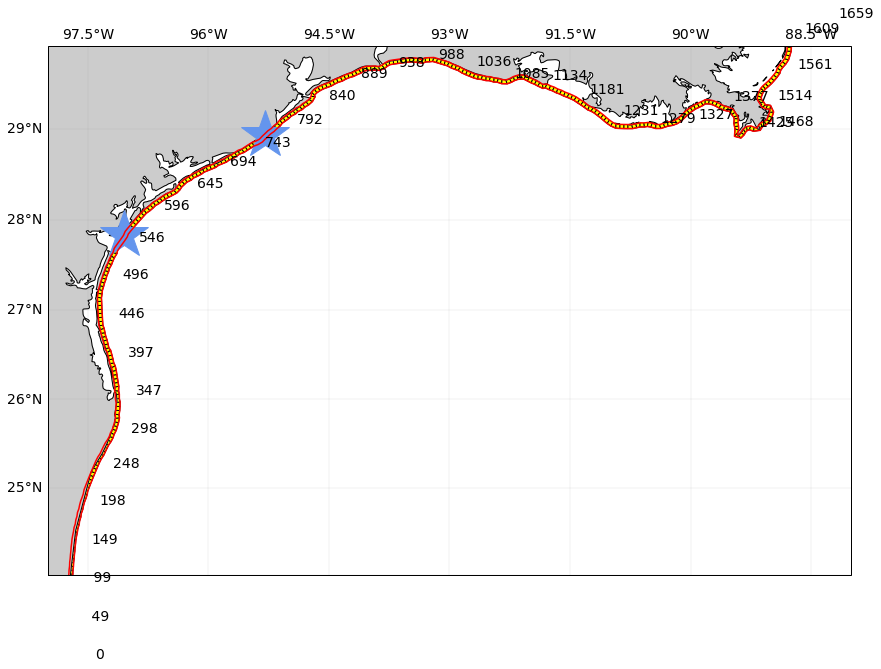

In [4]:
fig = plt.figure(figsize=(12, 8))# (9.4, 7.7))
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-98, -88, 23.5, 29.9], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  # coastline resolution options are '110m', '50m', '10m'

# Add outer path
ax.plot(loncoast, latcoast, 'r', transform=pc)

# Plot labels for boxes
for (i, path), dis in zip(enumerate(pathsg[::10]), dist[::10]):
    # convert from grid coords to ll to save
    pathslon, pathslat, _ = tracpy.tools.interpolate2d(path.vertices[:,0], path.vertices[:,1], grid, 'm_ij2ll')
    ax.text(pathslon[0] + 0.25, pathslat[0], '%3d' % dis, fontsize=14, color='k', transform=pc)
        

# # label boxes
# patches = []
# for i, path in enumerate(pathsg):
#     pathslon, pathslat, _ = tracpy.tools.interpolate2d(path.vertices[:,0], path.vertices[:,1], grid, 'm_ij2ll')
#     p = Path(np.vstack((pathslon,pathslat)).T)
#     ax.add_patch(Patches.PathPatch(p, facecolor='yellow', transform=pc))


In [6]:
np.interp(np.arange(0,1500,50), dist, )

make a line from along coast points

In [167]:
import shapely.geometry
coastll = shapely.geometry.LineString(zip(loncoast, latcoast))
ae = cartopy.crs.AzimuthalEquidistant(central_longitude=-94.5, central_latitude=28.5)
coastxy = ae.project_geometry(coastll, src_crs=pc)

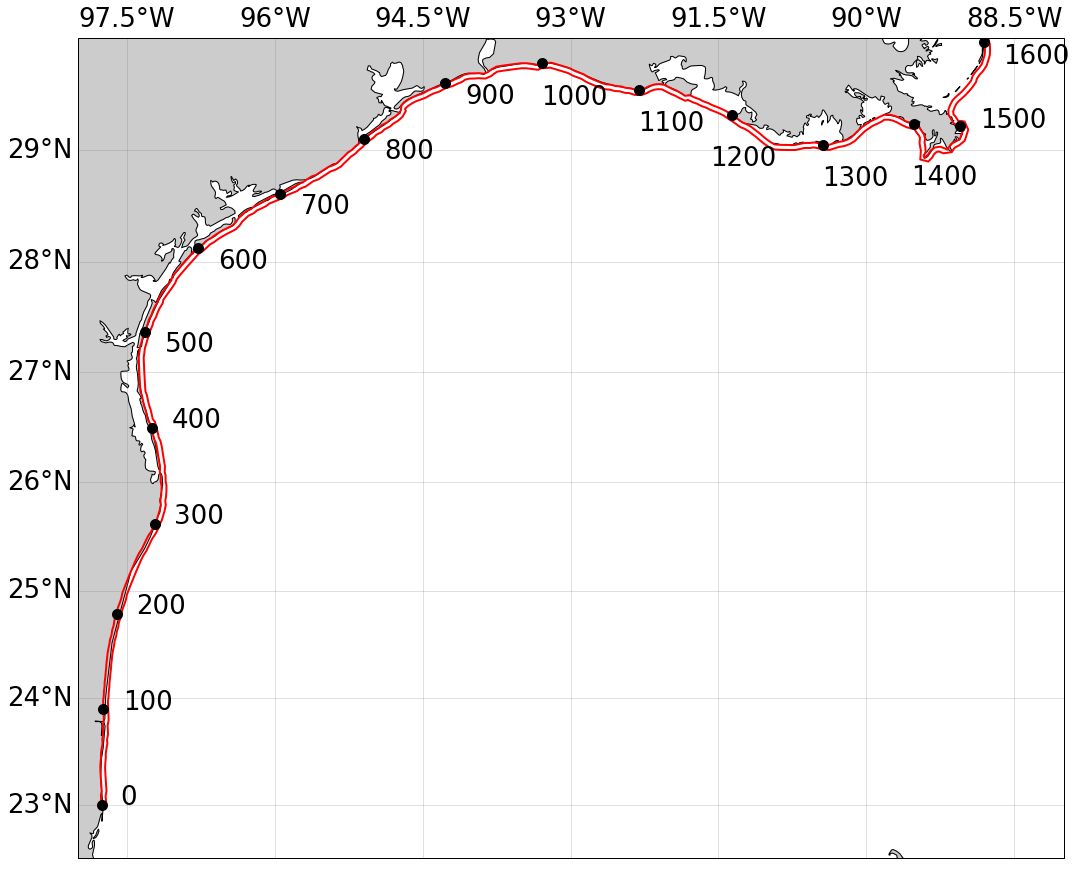

In [183]:
mpl.rcParams.update({'font.size': 26})
fig = plt.figure(figsize=(16, 12))# (9.4, 7.7))
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-98, -88, 22.5, 30], pc)
gl = ax.gridlines(linewidth=0.5, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  # coastline resolution options are '110m', '50m', '10m'

ax.plot(*coastxy[0].xy, color='r', lw=2, transform=ae)

for i, dd in enumerate(np.arange(0,1700000,100000)):
    if i <= 4:
        dx = 2e4; dy = 0
    elif i >= 5 and i <= 9:
        dx = 2e4; dy= -2e4
    elif i == 12:
        dx = -2e4; dy = -5e4
    elif i == 14:
        dx = 0; dy = -6e4
    elif i == 15:
        dx = 2e4; dy = 0
    elif i == 16:
        dx = 2e4; dy = -2e4
    elif i>=9:
        dx = 0; dy = -4e4
    pt = coastxy[0].interpolate(dd).xy
    ax.plot(*pt, '.', markersize=20, color='k', transform=ae)
    ax.text(pt[0][0] + dx, pt[1][0] + dy, '%d' % (dd/1000.), color='k', transform=ae)

In [87]:
pt[0][0]

-455182.82900420646

In [117]:
cartopy.crs.AzimuthalEquidistant?